# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: Alessio Barboni

**Matricola**: 2027647

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

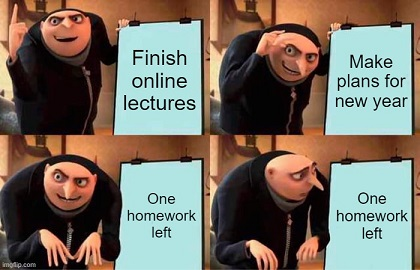

In [ ]:
import tensorflow as tf

### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

The dataset chosen for this homework is the *Flowers* dataset, it can be found on the catalog of *TensorFlow Datasets*, specifically on the section of image classification (at https://www.tensorflow.org/datasets/catalog/tf_flowers).

It's a rather small dataset since it has only 3,670 training samples (it comes with no validation/test split), it contains pictures of flowers and it has 5 classes in total (i.e., daisy, dandelion, roses, sunflowers, tulips). Also, its images are rather small in terms of size and actually have slightly different heights and widths (all in the 300-500pxl range).

So the task is *Fine-Grained Image Classification*.

In [ ]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

import tensorflow_datasets as tfds

train, validation, test = tfds.load('tf_flowers', split=['train[:2936]', 'train[2936:3303]', 'train[3303:]'], as_supervised=True) #80%-10-10%% train-validation-test split

print()
print("Training Set Length:,", len(train))
print("Validation Set Length:,",len(validation))
print("Test Set Length:,",len(validation))

def preprocess(img, label):
    image = tf.cast(img, tf.float32) / 255.0 # Scale data, from 0-255 to 0-1 range, (sc. min-max scaling)
    image = tf.image.resize(image, (100,100)) # Resize img, since they even have different sizes
    return image, label

train_data_p = train.map(preprocess).shuffle(len(train)).batch(16) # using a larger batch_size, fe. 32, was raising a ResourceExhaustedError (ie. exceeding colab's free limits) 
val_data_p = validation.map(preprocess).batch(16) 
test_data_p = test.map(preprocess).batch(16) 

myInputShape = (100, 100, 3)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.

Training Set Length:, 2936
Validation Set Length:, 367
Test Set Length:, 367


The motivation behind the choice of reducing the size of images to a lower resolution (ie. 100x100) was mainly influenced by the Colab's RAM/GPU usage limit (fe. it returned a "Your session crashed after using all available RAM" message during the training of a *ResNet-50* and even a *ResNet-34*, while using 224x224 images and a batch size of 16) and by the architecture chosen that is far from being shallow.

In [ ]:
#Is the dataset balanced?

import pandas as pd, numpy as np

ds_labels = tf.stack([y for x, y in train] + [y for x, y in validation] + [y for x, y in test], 0).numpy()
pd.DataFrame(ds_labels, columns = ['y']).groupby(['y'])["y"].count()

classes = ["dandelion", "daisy", "tulips", "sunflowers", "roses"]

y
0    898
1    633
2    799
3    699
4    641
Name: y, dtype: int64

The *Imbalance Ratio (IR)* is $\frac{898}{633} = 1.42$, which is rather small considering that *Long-Tailed* datasets usually have imbalance ratios much larger than 1 (e.g., 10 or even 100 for *CIFAR-10-LT* and *CIFAR-100-LT* respectively).

tf.Tensor(2, shape=(), dtype=int64)


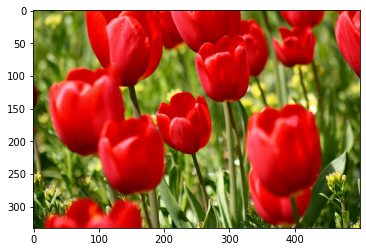

tf.Tensor(3, shape=(), dtype=int64)


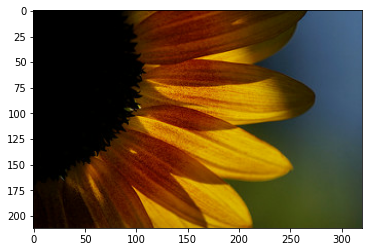

tf.Tensor(3, shape=(), dtype=int64)


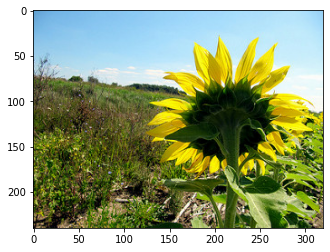

tf.Tensor(0, shape=(), dtype=int64)


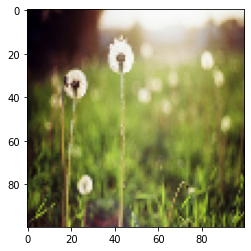

tf.Tensor(3, shape=(), dtype=int64)


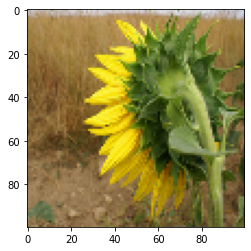

tf.Tensor(2, shape=(), dtype=int64)


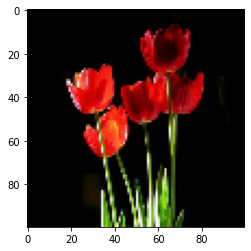

In [ ]:
import matplotlib.pyplot as plt

for xb, yb in train.take(3):
  print(yb)
  plt.imshow(xb)
  plt.show()

for xb, yb in train_data_p.take(3):
  print(yb[0])
  plt.imshow(xb[0])
  plt.show()


Above there are six examples of different images, three coming from the original train dataset, the others from the preprocessed train dataset.

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

The model chosen for this homework belongs to the family of *Residual Neural Networks (ResNet)*, which are models that have several advantages, eg. they ease the training of networks that are very deep and allow with their skip-connections the gradient to flow more easily through the network (potentially preventing the vanishing gradients problem) just to name a few. 

The picture below (taken from He et al. 2015) summarises the architectures of 5 different ResNet models, but many other variants exist.


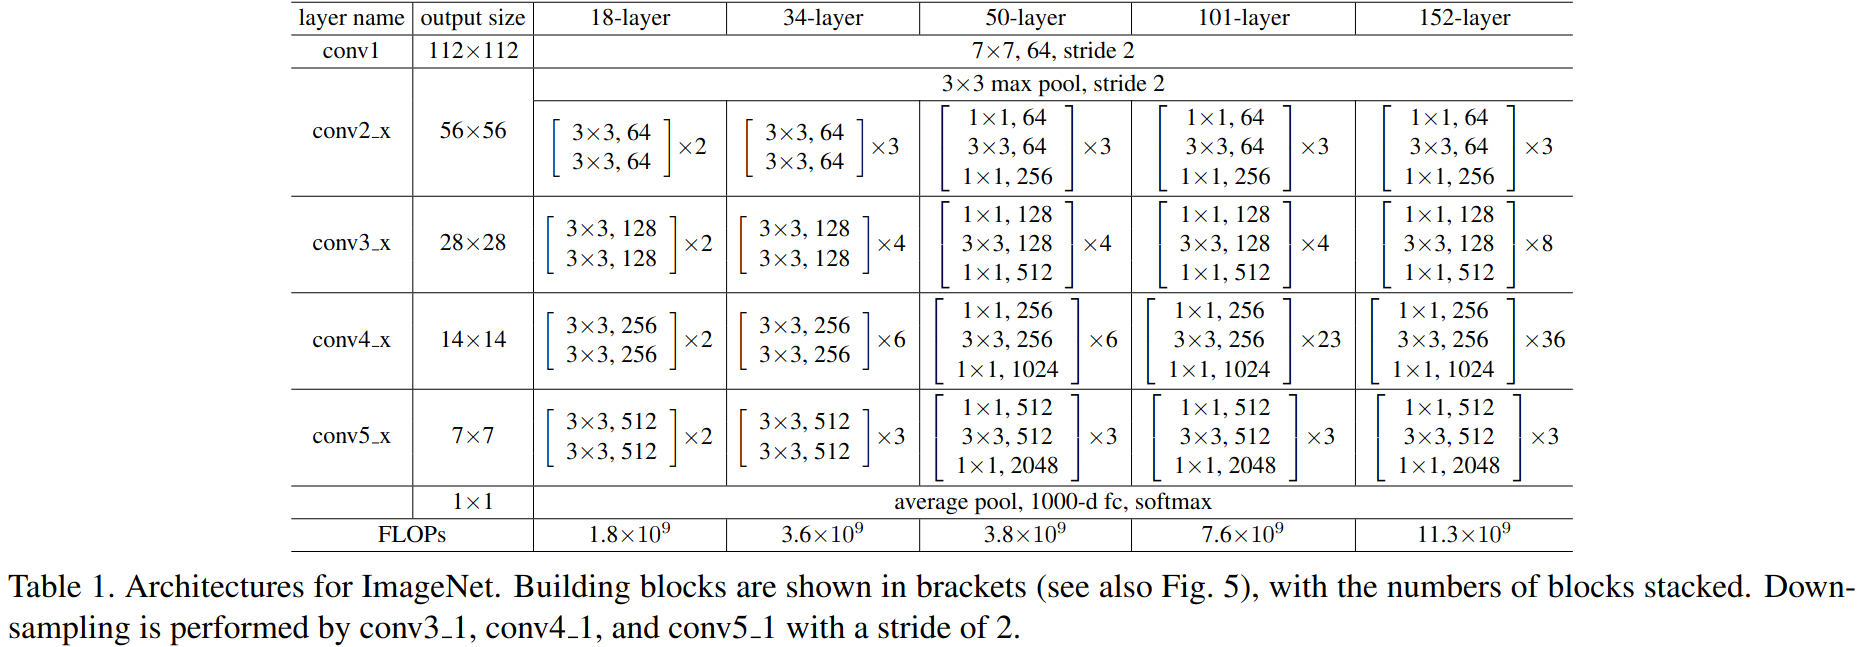

The idea now would be to create a script that works for any ResNet model, and then choose a specific architecture based on training time, performances, and the above-mentioned Colab's RAM and GPU usage limits.

Note: The inspiration for this code is taken from both the *Dive Into Deep Learning* book (Ch. 8.6 on ResNets) and the second Lab Session about CNN we had in class.

In [ ]:
# TODO: add the model definition and model training code here (as many cells as you need).

from tensorflow.keras import layers, initializers, regularizers

'''
A ResNet model is made by stacking many Residual Blocks, that are blocks made of Convolutional layers, Batch normalization layers and ReLu activation functions.
This function below will be responsible for adding Residual Blocks with the characteristics required by the specific architecture.
'''

def add_residual_block(x, obj, myStride = 1, conv1x1 = False):  
    
    #For ResNet-18 and ResNet-34 (or any other ResNet having 2 Conv layers per Residual Block)
    if len(obj) == 4:
      k1 = obj[0] # equal to k2, (as far as i could tell from the picture above)
      nF1 = obj[1] # equal to nF2

      f_x = layers.Conv2D(filters = nF1, kernel_size = k1, padding = 'same', strides = myStride)(x) 
      f_x = layers.BatchNormalization()(f_x)
      f_x = tf.nn.relu(f_x)

      f_x = layers.Conv2D(filters = nF1, kernel_size = k1, padding = 'same')(f_x) 
      f_x = layers.BatchNormalization()(f_x)
      
      if conv1x1: #this 1x1 convolution is used to reshape the input x (specifically its #channels) st. f_x and x 'd have the same shape, since the next op 'd be f_x+x
        x = layers.Conv2D(nF1, kernel_size = 1, strides = myStride)(x)

      f_x += x    
      return tf.nn.relu(f_x)
    
    #For ResNet-50, ResNet-101, ResNet-152 (or any other ResNet having 3 Conv layers per Residual Block) 
    else:
      k1, k2, k3 = obj[0], obj[2], obj[4]
      nF1, nF2, nF3 = obj[1], obj[3], obj[5]

      f_x = layers.Conv2D(filters = nF1, kernel_size = k1, padding = 'same', strides = myStride)(x) 
      f_x = layers.BatchNormalization()(f_x)
      f_x = tf.nn.relu(f_x)

      f_x = layers.Conv2D(filters = nF2, kernel_size = k2, padding = 'same')(x) 
      f_x = layers.BatchNormalization()(f_x)
      f_x = tf.nn.relu(f_x)

      f_x = layers.Conv2D(filters = nF3, kernel_size = k3, padding = 'same')(f_x) 
      f_x = layers.BatchNormalization()(f_x)
      
      if conv1x1:
        x = layers.Conv2D(filters = nF3, kernel_size = 1, strides = 1)(x)
      
      f_x += x    
      return tf.nn.relu(f_x)

In [ ]:
def build_model(arc, num_classes, lr, inp_shape): 

  inp = layers.Input(shape=inp_shape)
  
  # Define the first two layers, that are in common with every ResNet model (cf. figure above)
  x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inp)
  x = layers.BatchNormalization()(x)
  x = tf.nn.relu(x)
  x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

  # Next layers
  for j in range(len(arc)):
    for i in range(arc[j][0]):
      if len(arc[0][1])==4: # ie. if it's a ResNet-18 or ResNet-34
        if i == 0 and j != 0:
            x = add_residual_block(x, arc[j][1], 2, True)
        else:
            x = add_residual_block(x, arc[j][1], 1)
      if len(arc[0][1])==6: # ie. if it's a ResNet-50 or larger
        if i == 0 and j != 0:
            x = add_residual_block(x, arc[j][1], 2, True)
        elif i==0 and j==0:
            x = add_residual_block(x, arc[j][1], 1, True)
        else:
            x = add_residual_block(x, arc[j][1], 1)
        
  x = layers.GlobalAvgPool2D()(x)
  y = layers.Dense(units=num_classes)(x)

  return tf.keras.Model(inputs=inp, outputs=y)

In [ ]:
# Structure:
# resnet-x = ((number of resnet blocks, (kernel-first-convo-layer, filters-first-convo-layer, etc..)), ...)

resnet18 = ((2, (3, 64, 3, 64)),    
            (2, (3, 128, 3, 128)),
            (2, (3, 256, 3, 256)),
            (2, (3, 512, 3, 512))) 

resnet34 = ((3, (3, 64, 3, 64)), 
            (4, (3, 128, 3, 128)),
            (6, (3, 256, 3, 256)),
            (3, (3, 512, 3, 512))) 

resnet50 = ((3, (1, 64, 3, 64, 1, 256)), 
            (4, (1, 128, 3, 128, 1, 512)),
            (6, (1, 256, 3, 256, 1, 1024)),
            (3, (1, 512, 3, 512, 1, 2048))) 

model = build_model(resnet34, num_classes=5, lr=0.1, inp_shape = myInputShape)

In [ ]:
from tensorflow.keras import losses, metrics, optimizers, callbacks
cross_entropy = losses.SparseCategoricalCrossentropy(from_logits=True)
accuracy = metrics.SparseCategoricalAccuracy()
optimizer = optimizers.Adam()

model.compile(loss=cross_entropy, optimizer=optimizer, metrics=[accuracy])

# ResNet-50, batch_size 16
model.fit(train_data_p, validation_data=val_data_p, epochs=50)

Epoch 1/50
184/184 [==============================] - 137s 521ms/step - loss: 1.8496 - sparse_categorical_accuracy: 0.3975 - val_loss: 1.8816 - val_sparse_categorical_accuracy: 0.2534
Epoch 2/50
184/184 [==============================] - 92s 494ms/step - loss: 1.2874 - sparse_categorical_accuracy: 0.4976 - val_loss: 2.1339 - val_sparse_categorical_accuracy: 0.2589
Epoch 3/50
184/184 [==============================] - 90s 485ms/step - loss: 1.1459 - sparse_categorical_accuracy: 0.5538 - val_loss: 1.6172 - val_sparse_categorical_accuracy: 0.4305
Epoch 4/50
184/184 [==============================] - 92s 496ms/step - loss: 1.1008 - sparse_categorical_accuracy: 0.5722 - val_loss: 1.3274 - val_sparse_categorical_accuracy: 0.4741
Epoch 5/50
184/184 [==============================] - 92s 495ms/step - loss: 1.0685 - sparse_categorical_accuracy: 0.5872 - val_loss: 1.2425 - val_sparse_categorical_accuracy: 0.5368
Epoch 6/50
184/184 [==============================] - 92s 496ms/step - loss: 0.9956 

✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

In [ ]:
# TODO: add metrics and/or graphs showing the model was trained correctly.

In [ ]:
x, y = tf.stack([x for x, y in test_data_p]), tf.stack([y for x, y in test_data_p])
loss, acc = model.evaluate(x, y) 

12/12 [==============================] - 3s 268ms/step - loss: 1.0192 - sparse_categorical_accuracy: 0.7466


The accuracy is far from being the *state-of-the-art* on this dataset, but it must be noticed that the training was limited to only 50 epochs. Nevertheless, since the random threshold for a multiclass classification problem with 5 classes would be 0.20, I can conclude that it's rather good.

In [ ]:
y_pred = model.predict(test_data_p, batch_size=16)
y_pred = tf.math.argmax(y_pred, 1)

23/23 [==============================] - 6s 161ms/step


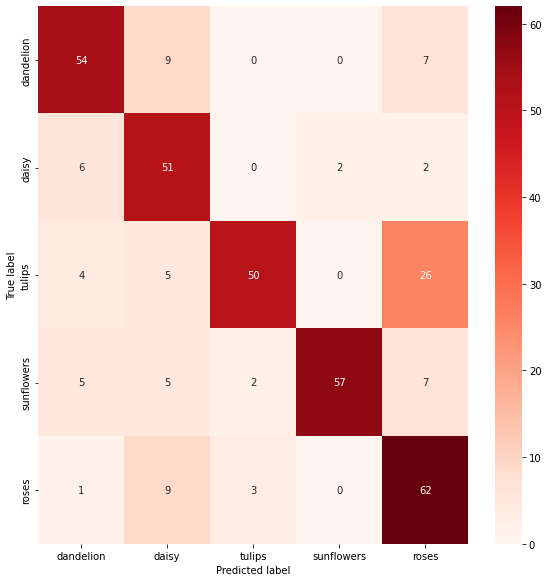

In [ ]:
# Confusion Matrix Plot

import seaborn as sns

cmatrix = tf.math.confusion_matrix(y, y_pred).numpy()
figure = plt.figure(figsize=(8, 8))
sns.heatmap(pd.DataFrame(cmatrix,index =classes,columns = classes), annot=True, cmap=plt.cm.Reds, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Overall, the model seems to be having problems mainly with the classification of tulips against roses (specifically misclassifying the former class as the latter). Potentially, this problem could be solved with some more extensive data preprocessing, by leaving the resolution of the images unchanged (since some images were originally 500x500, and were resized to 100x100, ie. a 5x decrease in resolution), or even by collecting more training data (since here it is limited to 3670 samples).

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred))
#Note: 0 -"dandelion", 1 - "daisy", 2 - "tulips", 3 - "sunflowers", 4 - "roses"

              precision    recall  f1-score   support

           0       0.77      0.77      0.77        70
           1       0.65      0.84      0.73        61
           2       0.91      0.59      0.71        85
           3       0.97      0.75      0.84        76
           4       0.60      0.83      0.69        75

    accuracy                           0.75       367
   macro avg       0.78      0.75      0.75       367
weighted avg       0.79      0.75      0.75       367



### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

Regarding the topic of adding modularity to the network, i decided to choose the Mixture-of-Experts variant.

I took the intuition behind its usage from "*Deep Neural Networks with Mixture of Experts Layers for Complex Event Recognition from Images*" (Li et al., 2018), since in this paper the MoE layer was applied specifically to a ResNet model. The idea is simply to add a MoE layer after the *Global Average Pooling* of the ResNet model.

However, the specific method they used is too simplistic, also with respect to what we saw in class, since they used a non-sparse gating function to route input images to experts.

Hence i have based the structure of the MoE layer on the method presented in *Outrageously Large Neural Networks: The Sparsely-Gated Mixture-Of-Experts Layer* (Shazeer et al. 2017), where:

$G(x) = Softmax (KeepTopK(H(x), k))$ is the sparse *gating function*.

$H(x)_i = (xW_g)_i + StdNormal()*SoftPlus((xW_{noise})_i)$

$(KeepTopK(v, k))_i = v_i $ if $v_i \in$ top-$k$ elements of $v$ else $-∞$

In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.

def build_model(arc, num_classes, lr, inp_shape, num_experts, k): 

  inp = layers.Input(shape=inp_shape)
  
  # Define the first two layers, that are in common with every ResNet model (cf. figure above)
  x = layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(inp)
  x = layers.BatchNormalization()(x)
  x = tf.nn.relu(x)
  x = layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)

  # Next layers
  for j in range(len(arc)):
    for i in range(arc[j][0]):
      if len(arc[0][1])==4: # ie. if it's a ResNet-18 or ResNet-34
        if i == 0 and j != 0:
            x = add_residual_block(x, arc[j][1], 2, True)
        else:
            x = add_residual_block(x, arc[j][1], 1)
      if len(arc[0][1])==6: # ie. if it's a ResNet-50 or larger
        if i == 0 and j != 0:
            x = add_residual_block(x, arc[j][1], 2, True)
        elif i==0 and j==0:
            x = add_residual_block(x, arc[j][1], 1, True)
        else:
            x = add_residual_block(x, arc[j][1], 1)
        
  x = layers.GlobalAvgPool2D()(x)

  # MoE Layer
  batch_size = tf.shape(x)[0] #tbd at runtime

  H = layers.Dense(units = num_experts)(x) + tf.random.normal(shape=[num_experts]) * tf.math.softplus(layers.Dense(units = num_experts)(x))
  temp = tf.math.top_k(H, k, sorted=True)
  temp_2 = tf.fill([batch_size, num_experts], -np.inf) #initialize a vector of all -Inf, later k of its elements 'd be replaced by the top k values found above

  idx = tf.reshape(temp.indices, shape=[batch_size*k]) # indices ASIS: ((idx_1, idx_2)_batch1, ...,(idx_1, idx_2)_lastBatch); indices TOBE: ((batch_1, idx_1), ... (lastBatch, idx_2)). Why? in order to use tf.tensor_scatter_nd_update
  t = tf.repeat(tf.range(batch_size), [k]) # create a tensor of: 0 0 1 1 2 2 3 3...
  new_idx = tf.transpose([t, idx]) 

  KeepTopK = tf.tensor_scatter_nd_update(temp_2, new_idx, tf.reshape(temp.values, [batch_size*k])) #replace the -Inf in the found indices with the top-k values  
  G = tf.nn.softmax(KeepTopK)

  # Create as many MLP experts as requested
  out = []
  for i in range(num_experts): 
    temp = layers.Dense(units=1000)(x)
    temp = tf.nn.relu(temp)
    expert_i = layers.Dense(units=num_classes)(temp)
    expert_i = tf.nn.softmax(expert_i)
    out.append(expert_i)
  
  E = tf.stack(out)
  E = tf.transpose(E, perm=[1, 2, 0])
  y_MoE = tf.einsum('ij,ikj->ik', G, E)
  
  return tf.keras.Model(inputs=inp, outputs=y_MoE)

The number of expert is set to 5, each expert is a MLP made of one hidden layer with 1000 node, and an output layer made of 10 nodes. A small number could be a good start due to the already-mentioned Colab's limitations.

Let's fine-tune the *k* instead, ie. the number of experts that would contribute to the prediction:

## *K* = 3

In [ ]:
resnet50Arc = ((3, (1, 64, 3, 64, 1, 256)), 
                 (4, (1, 128, 3, 128, 1, 512)),
                 (6, (1, 256, 3, 256, 1, 1024)),
                 (3, (1, 512, 3, 512, 1, 2048))) 

model = build_model(resnet50Arc, num_classes=5, lr=0.1, inp_shape = myInputShape, num_experts = 5, k = 3)

In [ ]:
from tensorflow.keras import losses, metrics, optimizers

cross_entropy = losses.SparseCategoricalCrossentropy(from_logits=False) 
accuracy = metrics.SparseCategoricalAccuracy()
optimizer = optimizers.Adam()
model.compile(loss=cross_entropy, optimizer=optimizer, metrics=[accuracy], run_eagerly=True) 

In [ ]:
#ResNet-50, batch 16, k 3
model.fit(train_data_p, validation_data=val_data_p, epochs=50)

Epoch 1/50


184/184 [==============================] - 142s 590ms/step - loss: 2.5534 - sparse_categorical_accuracy: 0.2701 - val_loss: 1.8786 - val_sparse_categorical_accuracy: 0.3379
Epoch 2/50
184/184 [==============================] - 105s 567ms/step - loss: 1.7726 - sparse_categorical_accuracy: 0.3430 - val_loss: 9.1398 - val_sparse_categorical_accuracy: 0.2616
Epoch 3/50
184/184 [==============================] - 106s 571ms/step - loss: 1.5458 - sparse_categorical_accuracy: 0.3849 - val_loss: 1.3745 - val_sparse_categorical_accuracy: 0.4741
Epoch 4/50
184/184 [==============================] - 106s 571ms/step - loss: 1.2753 - sparse_categorical_accuracy: 0.4683 - val_loss: 1.1182 - val_sparse_categorical_accuracy: 0.5722
Epoch 5/50
184/184 [==============================] - 106s 568ms/step - loss: 1.2335 - sparse_categorical_accuracy: 0.4932 - val_loss: 1.3445 - val_sparse_categorical_accuracy: 0.4387
Epoch 6/50
184/184 [==============================] - 106s 567ms/step - loss: 1.1810 - spar

## *K* = 5

In [ ]:
resnet50Arc = ((3, (1, 64, 3, 64, 1, 256)), 
                 (4, (1, 128, 3, 128, 1, 512)),
                 (6, (1, 256, 3, 256, 1, 1024)),
                 (3, (1, 512, 3, 512, 1, 2048))) 

model = build_model(resnet50Arc, num_classes=5, lr=0.1, inp_shape = myInputShape, num_experts = 5, k = 5)

In [ ]:
cross_entropy = losses.SparseCategoricalCrossentropy(from_logits=False) 
accuracy = metrics.SparseCategoricalAccuracy()
optimizer = optimizers.Adam()
model.compile(loss=cross_entropy, optimizer=optimizer, metrics=[accuracy], run_eagerly=True) 

In [ ]:
#ResNet-50, batch 16, k 5
model.fit(train_data_p, validation_data=val_data_p, epochs=50)

Epoch 1/50


184/184 [==============================] - 152s 646ms/step - loss: 3.0381 - sparse_categorical_accuracy: 0.2469 - val_loss: 1.5963 - val_sparse_categorical_accuracy: 0.2425
Epoch 2/50
184/184 [==============================] - 113s 610ms/step - loss: 2.1219 - sparse_categorical_accuracy: 0.3253 - val_loss: 2.1224 - val_sparse_categorical_accuracy: 0.2098
Epoch 3/50
184/184 [==============================] - 114s 611ms/step - loss: 1.6384 - sparse_categorical_accuracy: 0.3924 - val_loss: 1.4104 - val_sparse_categorical_accuracy: 0.3488
Epoch 4/50
184/184 [==============================] - 114s 611ms/step - loss: 1.3165 - sparse_categorical_accuracy: 0.4605 - val_loss: 1.2558 - val_sparse_categorical_accuracy: 0.4714
Epoch 5/50
184/184 [==============================] - 114s 612ms/step - loss: 1.2257 - sparse_categorical_accuracy: 0.4922 - val_loss: 1.2264 - val_sparse_categorical_accuracy: 0.4332
Epoch 6/50
184/184 [==============================] - 114s 615ms/step - loss: 1.1715 - spar

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

### Results for *K* = 3

In [ ]:
x, y = tf.stack([x for x, y in test_data_p]), tf.stack([y for x, y in test_data_p])
loss, acc = model.evaluate(x, y) 

12/12 [==============================] - 6s 320ms/step - loss: 0.9855 - sparse_categorical_accuracy: 0.7057


The accuracy seems to be slightly smaller with respect to the previous model (ie. the ResNet-50 without MoE layer)

In [ ]:
y_pred = model.predict(test_data_p, batch_size=16)
y_pred = tf.math.argmax(y_pred, 1)

23/23 [==============================] - 4s 178ms/step


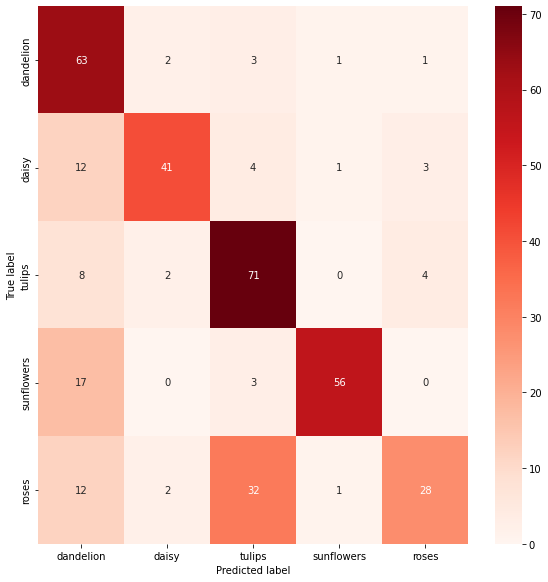

In [ ]:
#Confusion Matrix

cmatrix = tf.math.confusion_matrix(y, y_pred).numpy()
figure = plt.figure(figsize=(8, 8))
sns.heatmap(pd.DataFrame(cmatrix,index =classes,columns = classes), annot=True, cmap=plt.cm.Reds, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Also, the confusion matrix is less optimal compared to the previous model, eg. for the roses class the model makes more errors than correct predictions.

In [ ]:
print(classification_report(y, y_pred))
#Note: 0 -"dandelion", 1 - "daisy", 2 - "tulips", 3 - "sunflowers", 4 - "roses"

              precision    recall  f1-score   support

           0       0.56      0.90      0.69        70
           1       0.87      0.67      0.76        61
           2       0.63      0.84      0.72        85
           3       0.95      0.74      0.83        76
           4       0.78      0.37      0.50        75

    accuracy                           0.71       367
   macro avg       0.76      0.70      0.70       367
weighted avg       0.75      0.71      0.70       367



Let's inspect the matrix of weight of the sparse gating function $W_g$:

$W_g$ is implemented as a dense layer with 5 units, and it can be found in the model.summary() below (it is the dense layer after the globalAvgPool with output shape (None, 5) and that is **not** "Connected to" tf.math.softplus).                      


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 50, 50, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 50, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
# Sum of the weights for each of the 5 experts

ly = model.get_layer("dense") #"dense" is the exact name of the layer in the model
w = ly.get_weights()[0]
w.sum(axis=0)

array([  7.8494005 , -48.383938  , -21.272184  ,  -0.76995444,
        17.235607  ], dtype=float32)

The sum of the weights for each expert ($\sum_e W_g$) is used to determine which experts were used the most (since low weights reduce the probability that an expert would give a meaningful/any contribution to the prediction). In this case, this sum is actually negative for the second, third and fourth experts, and it could potentially indicate that these experts are not being effectively utilized by the model. This in theory could limit the capacity of the model, and potentially it could be solved with more training or more data.

### Results for *K* = 5

In [ ]:
x, y = tf.stack([x for x, y in test_data_p]), tf.stack([y for x, y in test_data_p])
loss, acc = model.evaluate(x, y)

12/12 [==============================] - 6s 331ms/step - loss: 0.8915 - sparse_categorical_accuracy: 0.7548


The accuracy on the test set is slightly larger with respect to the previous two models.

In [ ]:
y_pred = model.predict(test_data_p, batch_size=16)
y_pred = tf.math.argmax(y_pred, 1)

23/23 [==============================] - 4s 181ms/step


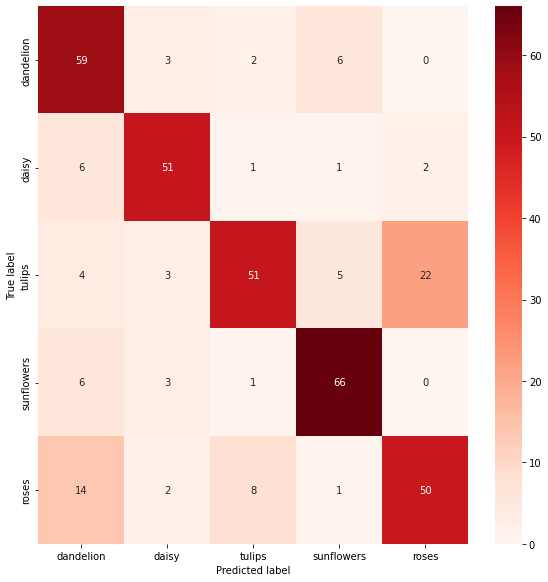

In [ ]:
#Confusion Matrix

cmatrix = tf.math.confusion_matrix(y, y_pred).numpy()
figure = plt.figure(figsize=(8, 8))
sns.heatmap(pd.DataFrame(cmatrix,index =classes,columns = classes), annot=True, cmap=plt.cm.Reds, fmt='g')
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y, y_pred))
#Note: 0 -"dandelion", 1 - "daisy", 2 - "tulips", 3 - "sunflowers", 4 - "roses"

              precision    recall  f1-score   support

           0       0.66      0.84      0.74        70
           1       0.82      0.84      0.83        61
           2       0.81      0.60      0.69        85
           3       0.84      0.87      0.85        76
           4       0.68      0.67      0.67        75

    accuracy                           0.75       367
   macro avg       0.76      0.76      0.76       367
weighted avg       0.76      0.75      0.75       367



In [ ]:
# model.summary()

In [ ]:
ly = model.get_layer("dense") #since dense_1 is the one passed to the softplus, check the model.summary()
w = mb.get_weights()[0]
w.sum(axis=0)

array([-12.896367, -13.569303,  15.321596,  44.537197,   7.952771],
      dtype=float32)

In this case the model seems to be using 3 out of 5 experts in an efficient way, and this might be also the reason why it achieved an higher accuracy. In conclusion, since the overall accuracy of the model is quite high (especially for a multiclass classification problem, with few data, and trained with a small number of epochs), these negative weights probably are not to be considered as a cause for concern.

### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

In [ ]:
# TODO: add code here. Train again the model with the new regularization loss.

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

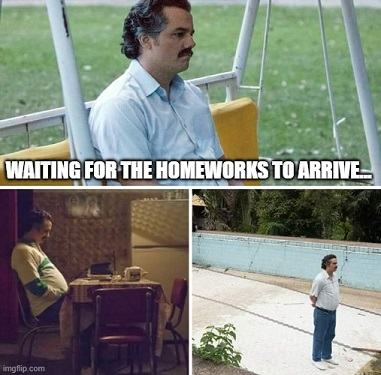